In [4]:
# SET UP (it will take a long time to run)
using Pkg; Pkg.activate("C:/Users/nicot/GitHub/Tutorial_DynMacro")
using Plots; using Optim; using Interpolations; using LinearAlgebra
Pkg.status()

  Activating environment at `C:\Users\nicot\GitHub\Tutorial_DynMacro\Project.toml`

      Status `D:\GitHub\Tutorial_DynMacro\Project.toml`


  [31c24e10] Distributions v0.23.11
  [2774e3e8] NLsolve v4.5.1
  [429524aa] Optim v1.4.1
  [fcd29c91] QuantEcon v0.16.2


# Ejercicio examen (versión 1)

Consideremos un modelo de ciclo real clásico, pero incorporando una restricción de no-negatividad sobre la inversión.


Función de producción Cobb-Douglas sin trabajo: $f(K)=AK^\alpha$.

Denotando a $Y$ como la producción tenemos $Y_t=f(K_{t-1})$.

Conocemos las condiciones iniciales $K_{-1}$.



Las preferencias están dadas por una función de Bernoulli (o utilidad instantánea) CRRA con parámetro $\gamma$:

Si $\gamma \neq 1$ entonces $u(c)=\frac{c^{1-\gamma}-1}{1-\gamma}$ 

Si $\gamma = 1$ entonces $u(c)=ln(c)$ 

La utilidad esperada intertemporal está dada por

$U_0(\{C_t\}_{t=0}^\infty) = \sum_{t=0}^\infty \beta^{t} u(C_t) $

$C_t\geq0$



El capital se deprecia a una tasa $\delta$ de forma que:

$K_t=K_{t-1}(1-\delta)+I_t$ (para todo $t$)

Donde $K_t>0$

**A difernecia de lo habitual impondremos:** $I_t\geq0$



Nos limitaremos al problema del planner, que podemos definirlo como:

$$
V(K_{-1}) = \max_{\{C_t\}_{t=0}^\infty,\{I_t\}_{t=0}^\infty} \sum_{t=0}^\infty \beta^{t} u(C_t) 
$$

sujeto a:
$$
AK_{t-1}^\alpha \geq I_t+C_t\\
K_t=K_{t-1}(1-\delta)+I_t\\
K_t\geq0\;I_t\geq0\;C_t\geq0\\
U_0(\{C_t\}_{t=0}^\infty)<\infty
$$

### Consignas

1. Escriba la ecuación de Bellman que caracteriza este problema. Muestre que la $V$ es única y continua.

2. Defina un equilibrio recursivo para este modelo

Para la siguiente calibración del modelo:

- $\gamma=1$
- $\beta = 0.95$
- $\delta = 0.005$
- $\alpha = 0.5$


Utilizando VFI se pide:

3. Compute la evolución temporal de la inversión, el stock de capital, el producto y el consumo si $K_0=80$. Muestre cómo sería la trayectoria de dichas variables para un modelo sin la restricción de no-negatividad sobre al inversión. 

4. Compute la evolución temporal de la inversión, si $K_0=30$. Muestre en un mismo gráfico cómo sería la trayectoria de dicha variable para un modelo sin la restricción de no-negatividad sobre al inversión. 

In [53]:
γ = 2.0
α = 0.27 
𝛿 = 0.005
A = 1
β = 0.984
@show K_0 = 80.0 # initial condition

u(c) = γ==1.0 ?  log(c)  :  c^(1-γ)/(1-γ)   # CRRA

f(k)=A*k^α + (1-𝛿)*k # Cobb-Douglas with depretiation

@show Kss_max = ((A*β*α)/(1-β*(1-𝛿)))^(1/(1-α))

n=500 # grid points
K_grid = range(1e-5, max(K_0,Kss_max), length=n)

V_0(k) = u(f(k)-k)/(1-β)

K_0 = 80.0 = 80.0
Kss_max = ((A * β * α) / (1 - β * (1 - 𝛿))) ^ (1 / (1 - α)) = 32.51254264066984


V_0 (generic function with 1 method)

In [54]:
function T_Ipos(V, K_grid)
    V_fun = LinearInterpolation(K_grid, V, extrapolation_bc = Line()) # linear interpolation of the vectorized (or not) function

    objectives = (K -> u.((f(k)-K)) + β * V_fun(K)  for k in K_grid)
    
    results = maximize.(objectives, K_grid.*(1-𝛿),f.(K_grid)) 

    V_new = Optim.maximum.(results)
    g_new = Optim.maximizer.(results)

    return V_new, g_new
end

function T_comun(V, K_grid)
    V_fun = LinearInterpolation(K_grid, V, extrapolation_bc = Line()) # linear interpolation of the vectorized (or not) function

    objectives = (K -> u.((f(k)-K)) + β * V_fun(K)  for k in K_grid)
    
    K_min=K_grid[1]
    results = maximize.(objectives, K_min,f.(K_grid)) 

    V_new = Optim.maximum.(results)
    g_new = Optim.maximizer.(results)

    return V_new, g_new
end


T_comun (generic function with 1 method)

In [55]:
V=V_0.(K_grid) # dicretized form of V_0
g=f.(K_grid)-(K_grid) # initial polcy function consisten with V_0

pltV=plot(K_grid, V, color = :black, linewidth = 2, alpha = 0.8, label = "initial condition")
pltg=plot(K_grid, g, color = :black, linewidth = 2, alpha = 0.8, label = "initial condition")

max_iter = 200   
tol = 1e-10 # tolerance, if distance is below that I'm fine
distance=tol+1 # some initial condition for distance
i=1
while i < max_iter && distance > tol
    global V_new, g_new = T_Ipos(V, K_grid)
    plot!(pltV,K_grid, V_new, color = RGBA(i/max_iter, 0, 1 - i/max_iter, 0.8), linewidth = 2, alpha = 0.6, label = "")
    plot!(pltg,K_grid, g_new, color = RGBA(i/max_iter, 0, 1 - i/max_iter, 0.8), linewidth = 2, alpha = 0.6, label = "")
    distance = norm(V_new - V)
    i += 1
    V = V_new  # copy contents into v.  Also could have used v[:] = v_next
end
g_Ipos=LinearInterpolation(K_grid, g_new, extrapolation_bc = Line()) # policy function K_t => K_t+1

println("Number of iterations: ",i,"\nDistance between last two value functions: ",distance)

plot!(pltV, legend = :bottomright, title="Value Function Iteration")
plot!(pltg, legend = :topleft, title="Policy Function Iteration")
plot(pltV, pltg)

Number of iterations: 200
Distance between last two value functions: 9.512708200592633e-5


In [56]:
V=V_0.(K_grid) # dicretized form of V_0
g=f.(K_grid)-(K_grid) # initial polcy function consisten with V_0

pltV=plot(K_grid, V, color = :black, linewidth = 2, alpha = 0.8, label = "initial condition")
pltg=plot(K_grid, g, color = :black, linewidth = 2, alpha = 0.8, label = "initial condition")

max_iter = 200   
tol = 1e-10 # tolerance, if distance is below that I'm fine
distance=tol+1 # some initial condition for distance
i=1
while i < max_iter && distance > tol
    global V_new, g_new = T_comun(V, K_grid)
    plot!(pltV,K_grid, V_new, color = RGBA(i/max_iter, 0, 1 - i/max_iter, 0.8), linewidth = 2, alpha = 0.6, label = "")
    plot!(pltg,K_grid, g_new, color = RGBA(i/max_iter, 0, 1 - i/max_iter, 0.8), linewidth = 2, alpha = 0.6, label = "")
    distance = norm(V_new - V)
    i += 1
    V = V_new  # copy contents into v.  Also could have used v[:] = v_next
end
g_comun=LinearInterpolation(K_grid, g_new, extrapolation_bc = Line()) # policy function K_t => K_t+1

println("Number of iterations: ",i,"\nDistance between last two value functions: ",distance)

plot!(pltV, legend = :bottomright, title="Value Function Iteration")
plot!(pltg, legend = :topleft, title="Policy Function Iteration")
plot(pltV, pltg)

Number of iterations: 200
Distance between last two value functions: 4.186736479081489e-5


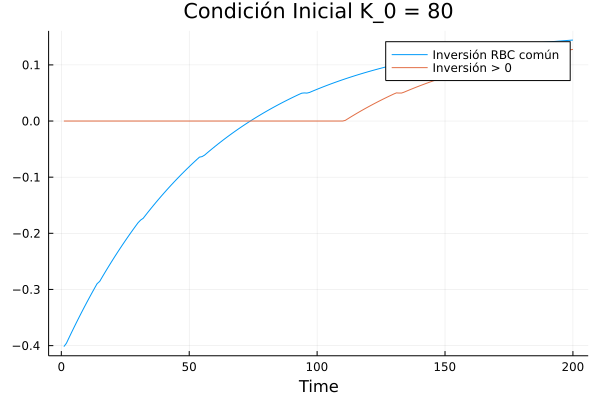

In [72]:
Time=200
K_0_1=80
y_Ipos = ones(Time)
I_Ipos = ones(Time)
K_Ipos = ones(Time)
c_Ipos = ones(Time)
y_comun = ones(Time)
I_comun = ones(Time)
K_comun = ones(Time)
c_comun = ones(Time)

y_Ipos[1] = A*K_0_1^α
K_Ipos[1] = g_Ipos(K_0_1)
I_Ipos[1] = K_Ipos[1] - K_0_1*(1-𝛿)
y_comun[1] = A*K_0_1^α
K_comun[1] = g_comun(K_0_1)
I_comun[1] = K_comun[1] - K_0_1*(1-𝛿)

for t in 2:(Time)  
    K_Ipos[t] = g_Ipos( K_Ipos[t-1] )
    I_Ipos[t] = K_Ipos[t] - K_Ipos[t-1]*(1-𝛿)
    y_Ipos[t] = A*K_Ipos[t-1]^α

    K_comun[t] = g_comun( K_comun[t-1] )
    I_comun[t] = K_comun[t] - K_comun[t-1]*(1-𝛿)
    y_comun[t] = A*K_comun[t-1]^α
end

c_Ipos = y_Ipos - I_Ipos
c_comun = y_comun - I_comun

plot(1:Time,I_comun,label="Inversión RBC común",title="Condición Inicial K_0 = $K_0_1",xlabel="Time")
plot!(1:Time,I_Ipos,label="Inversión > 0")
#plot!(1:Time,y_path,label="Production")

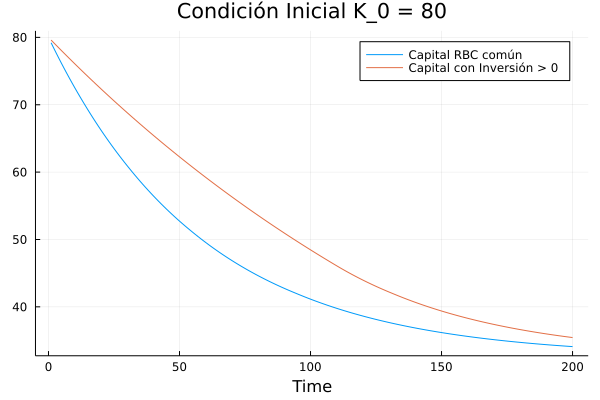

In [70]:
plot(1:Time,K_comun,label="Capital RBC común",title="Condición Inicial K_0 = $K_0_1",xlabel="Time")
plot!(1:Time,K_Ipos,label="Capital con Inversión > 0")

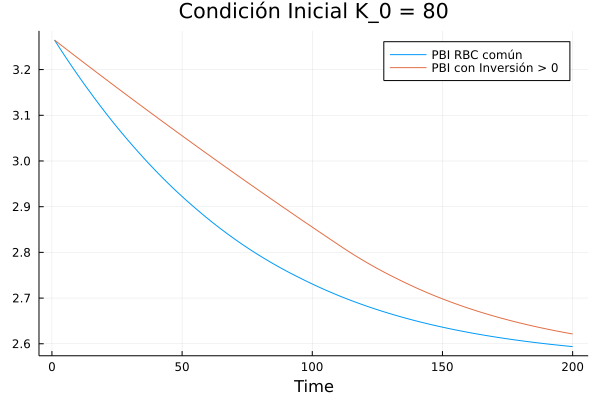

In [71]:
plot(1:Time,y_comun,label="PBI RBC común",title="Condición Inicial K_0 = $K_0_1",xlabel="Time")
plot!(1:Time,y_Ipos,label="PBI con Inversión > 0")

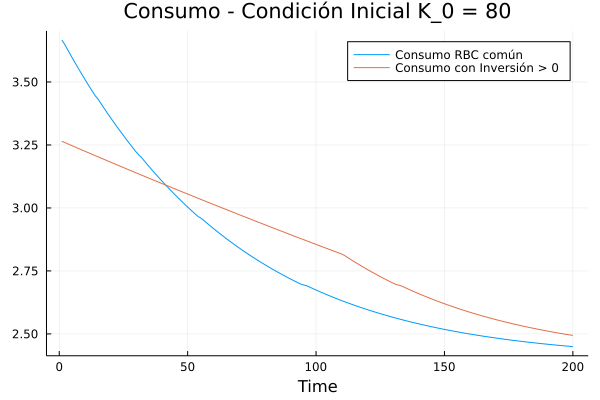

In [75]:
plot(1:Time,c_comun,label="Consumo RBC común",title="Consumo - Condición Inicial K_0 = $K_0_1",xlabel="Time")
plot!(1:Time,c_Ipos,label="Consumo con Inversión > 0")

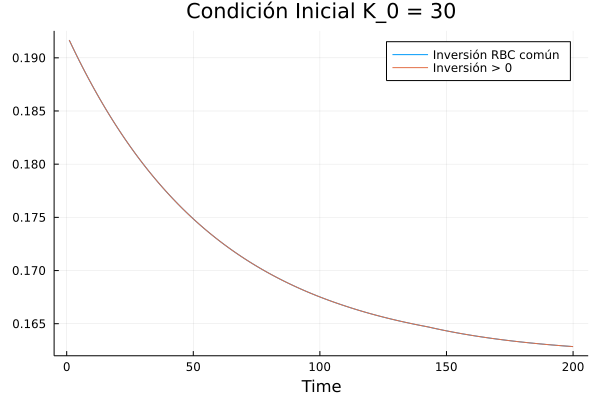

In [76]:
Time=200
K_0_1=30
y_Ipos = ones(Time)
I_Ipos = ones(Time)
K_Ipos = ones(Time)
c_Ipos = ones(Time)
y_comun = ones(Time)
I_comun = ones(Time)
K_comun = ones(Time)
c_comun = ones(Time)

y_Ipos[1] = A*K_0_1^α
K_Ipos[1] = g_Ipos(K_0_1)
I_Ipos[1] = K_Ipos[1] - K_0_1*(1-𝛿)
y_comun[1] = A*K_0_1^α
K_comun[1] = g_comun(K_0_1)
I_comun[1] = K_comun[1] - K_0_1*(1-𝛿)

for t in 2:(Time)  
    K_Ipos[t] = g_Ipos( K_Ipos[t-1] )
    I_Ipos[t] = K_Ipos[t] - K_Ipos[t-1]*(1-𝛿)
    y_Ipos[t] = A*K_Ipos[t-1]^α

    K_comun[t] = g_comun( K_comun[t-1] )
    I_comun[t] = K_comun[t] - K_comun[t-1]*(1-𝛿)
    y_comun[t] = A*K_comun[t-1]^α
end

c_Ipos = y_Ipos - I_Ipos
c_comun = y_comun - I_comun

plot(1:Time,I_comun,label="Inversión RBC común",title="Condición Inicial K_0 = $K_0_1",xlabel="Time")
plot!(1:Time,I_Ipos,label="Inversión > 0")
#plot!(1:Time,y_path,label="Production")